In [33]:
## https://lashlock.github.io/compbio/R_presentation.html

In [34]:
# Store current verbose option
suppressPackageStartupMessages({
    library(DESeq2,quietly = TRUE)
    library(ggplot2,quietly = TRUE)
    library(pheatmap)
    library(dplyr)
})

## Uploading and selecting the data

In [35]:
counts <- read.delim("all_samples_count.tsv", header = TRUE, sep = "\t")
genes <- counts[,1]
counts <- counts[,-1]
row.names(counts) <- genes
head(counts)

,B1,B2,B3,B4,B5,B6,B7,B8,B9,S1,⋯,rerun_V1,rerun_V10,rerun_V2,rerun_V3,rerun_V4,rerun_V5,rerun_V6,rerun_V7,rerun_V8,rerun_V9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NLLv2_murdoch00001.1,0,0,0,0,0.00000,0,0,2.00000,0,0,⋯,0,0,0,0,0,0,0,0,0,0
NLLv2_murdoch00002.1,0,0,1,0,3.00345,0,0,1.00145,0,0,⋯,0,0,0,0,0,0,0,0,0,0
NLLv2_murdoch00003.1,3931,2906,3956,4152,2883.00000,5299,7927,3312.00000,5474,7193,⋯,1358,1587,2922,782,742,1139,1150,1293,1318,1867
NLLv2_murdoch00004.1,137,210,262,235,297.00000,382,257,343.00000,371,244,⋯,116,145,317,84,34,134,131,96,77,70
NLLv2_murdoch00005.1,2450,3257,3071,3469,3436.00000,4203,1633,3833.00000,4673,1209,⋯,2157,2640,4322,1313,1187,2311,2163,1391,1318,2139
NLLv2_murdoch00006.1,5230,4701,4664,7024,4443.00000,6101,7119,5765.00000,7070,7198,⋯,2783,3587,6875,1639,1672,2955,2905,2775,2452,3311


In [36]:
xp_design <- read.delim("design.txt", header = TRUE, stringsAsFactors = FALSE, colClasses = rep("character",3))

xp_design = xp_design %>% filter(trait == "1" )
head(xp_design)

,sample,condition1,condition2,condition3,trait
,<chr>,<chr>,<chr>,<chr>,<chr>
1,rerun_V1,Bitter,control,leaf,1
2,rerun_V3,Bitter,control,leaf,1
3,rerun_V5,Bitter,control,leaf,1
4,rerun_V2,Bitter,control,leaf,1
5,rerun_V10,Bitter,control,leaf,1
6,rerun_V4,Bitter,VIGS,leaf,1


In [37]:
counts <- counts[, xp_design$sample]
head(counts,2)

,rerun_V1,rerun_V3,rerun_V5,rerun_V2,rerun_V10,rerun_V4,rerun_V7,rerun_V8,rerun_V9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NLLv2_murdoch00001.1,0,0,0,0,0,0,0,0,0
NLLv2_murdoch00002.1,0,0,0,0,0,0,0,0,0


In [38]:
## Check that sample names match in both files
all(colnames(counts) %in% xp_design$sample)
all(colnames(counts) == xp_design$sample)

[1] TRUE

[1] TRUE

## Get the differentially expressed genes

In [39]:
normalize <- function(countdata, xp_design, f, p){
  col.names = colnames(xp_design)                                             
  columns.to.discard = c("sample","condition1","condition3","trait")
  colsForConditions = col.names[! col.names %in% columns.to.discard]
    print(length(colsForConditions))
      # one condition
  if (length(colsForConditions) == 1){
    condition <- factor(xp_design[,colsForConditions])
    # two conditions
  } else if (length(colsForConditions) == 2){
    # two conditions --> make a third column that is the product of the two
    xp_design$conditions = paste(xp_design[,colsForConditions[1]],xp_design[,colsForConditions[2]],sep = ".")
    condition <- factor(x = xp_design[,"conditions"],levels = unique(xp_design[,"conditions"]))
  } else if (length(colsForConditions) == 3){
    xp_design$conditions = paste(xp_design[,colsForConditions[1]],xp_design[,colsForConditions[2]],xp_design[,colsForConditions[3]],sep = ".")
    condition <- factor(x = xp_design[,"conditions"],levels = unique(xp_design[,"conditions"]))
  }
      # Analysis with DESeq2
  # Create a coldata frame and instantiate the DESeqDataSet. See ?DESeqDataSetFromMatrix
  coldata <- data.frame(row.names=colnames(countdata), condition)
  dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
  # Run the DESeq pipeline
  dds <- DESeq(dds)
  # create dataframe containing normalized counts, to which the differential expression values will be added
  resdata <- as.data.frame(counts(dds, normalized=TRUE))
  # iterate through the list of conditions to create differential expression (DE) values for all possible pairs
  total_selec <- list()
  x <- 1
  for(i in levels(condition)){
    x <- x + 1
    if (x <= length(levels(condition))){
      for(j in x:length(levels(condition))){
        res <- results(dds, contrast=c("condition", i,  levels(condition)[j]))                      # i = first in pair, levels(condition)[j] is the second in pair.
        d <- paste(i, levels(condition)[j], sep="&")                                                # paste the two conditions in one character, to be used as the pair name
        res$genenames <- rownames(res)
        resul <- as.data.frame(res)
        significantDE <- resul %>% filter(padj<p & (log2FoldChange>f | log2FoldChange<(-1*f)) )
        selec <- as.list(significantDE$genenames)
        total_selec <- append(total_selec, selec)
      }
    }
  }
  total_selec <- c(unique(total_selec))
  total_selec <- t(as.data.frame(total_selec))
  selection <- resdata[total_selec[,1],]

  return(selection)
}

In [40]:
## Running the function

In [41]:
dim(counts)
dim(xp_design)

[1] 67183     9

[1] 9 5

In [42]:
#converting counts to integer
counts <- round(counts)

In [43]:
DEgenes <- normalize(counts,xp_design,2,0.01)

[1] 1


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [44]:
dim(DEgenes)

[1] 2001    9

## Scaling the data,Hierarchical tree of the samples

In [45]:
DEgenes <- as.matrix(DEgenes)
scaledata <- t(scale(t(DEgenes)))

In [46]:
hc <- hclust(as.dist(1-cor(scaledata, method="spearman")), method="complete") # Clusters columns by Spearman correlation.

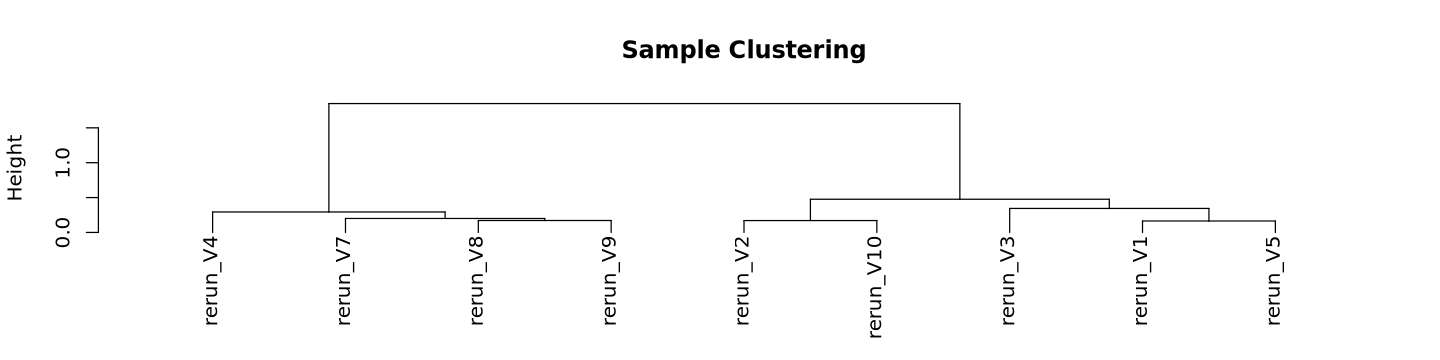

In [47]:
sampleTree = as.dendrogram(hc, method="average")
plot(sampleTree,
     main = "Sample Clustering",
     ylab = "Height")

In [48]:
# Hierarchical tree of the genes
hr <- hclust(as.dist(1-cor(t(scaledata), method="pearson")), method="complete") # Cluster rows by Pearson correlation.

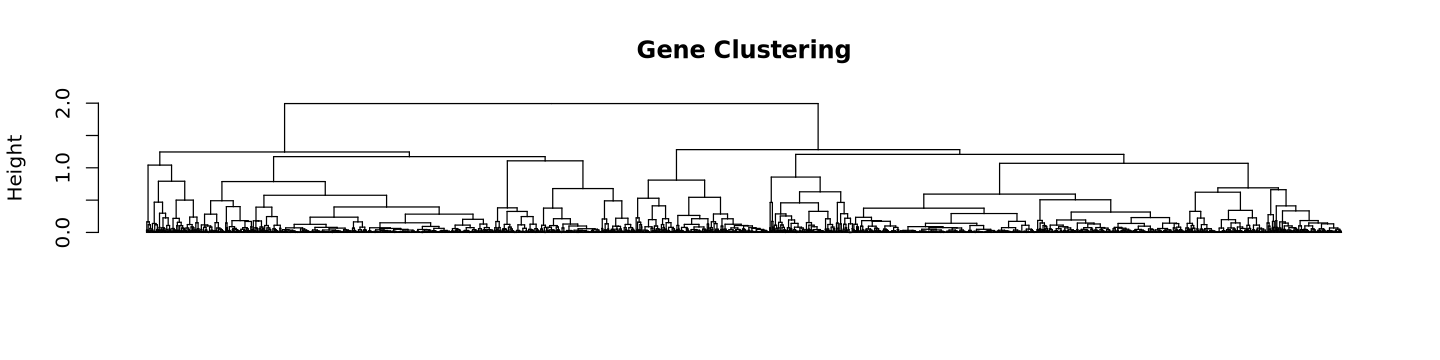

In [49]:
geneTree = as.dendrogram(hr, method="average")
plot(geneTree,
     leaflab = "none",             
     main = "Gene Clustering",
     ylab = "Height")

## Create a heatmap of the data.

In [50]:
library(gplots)

png 
  2

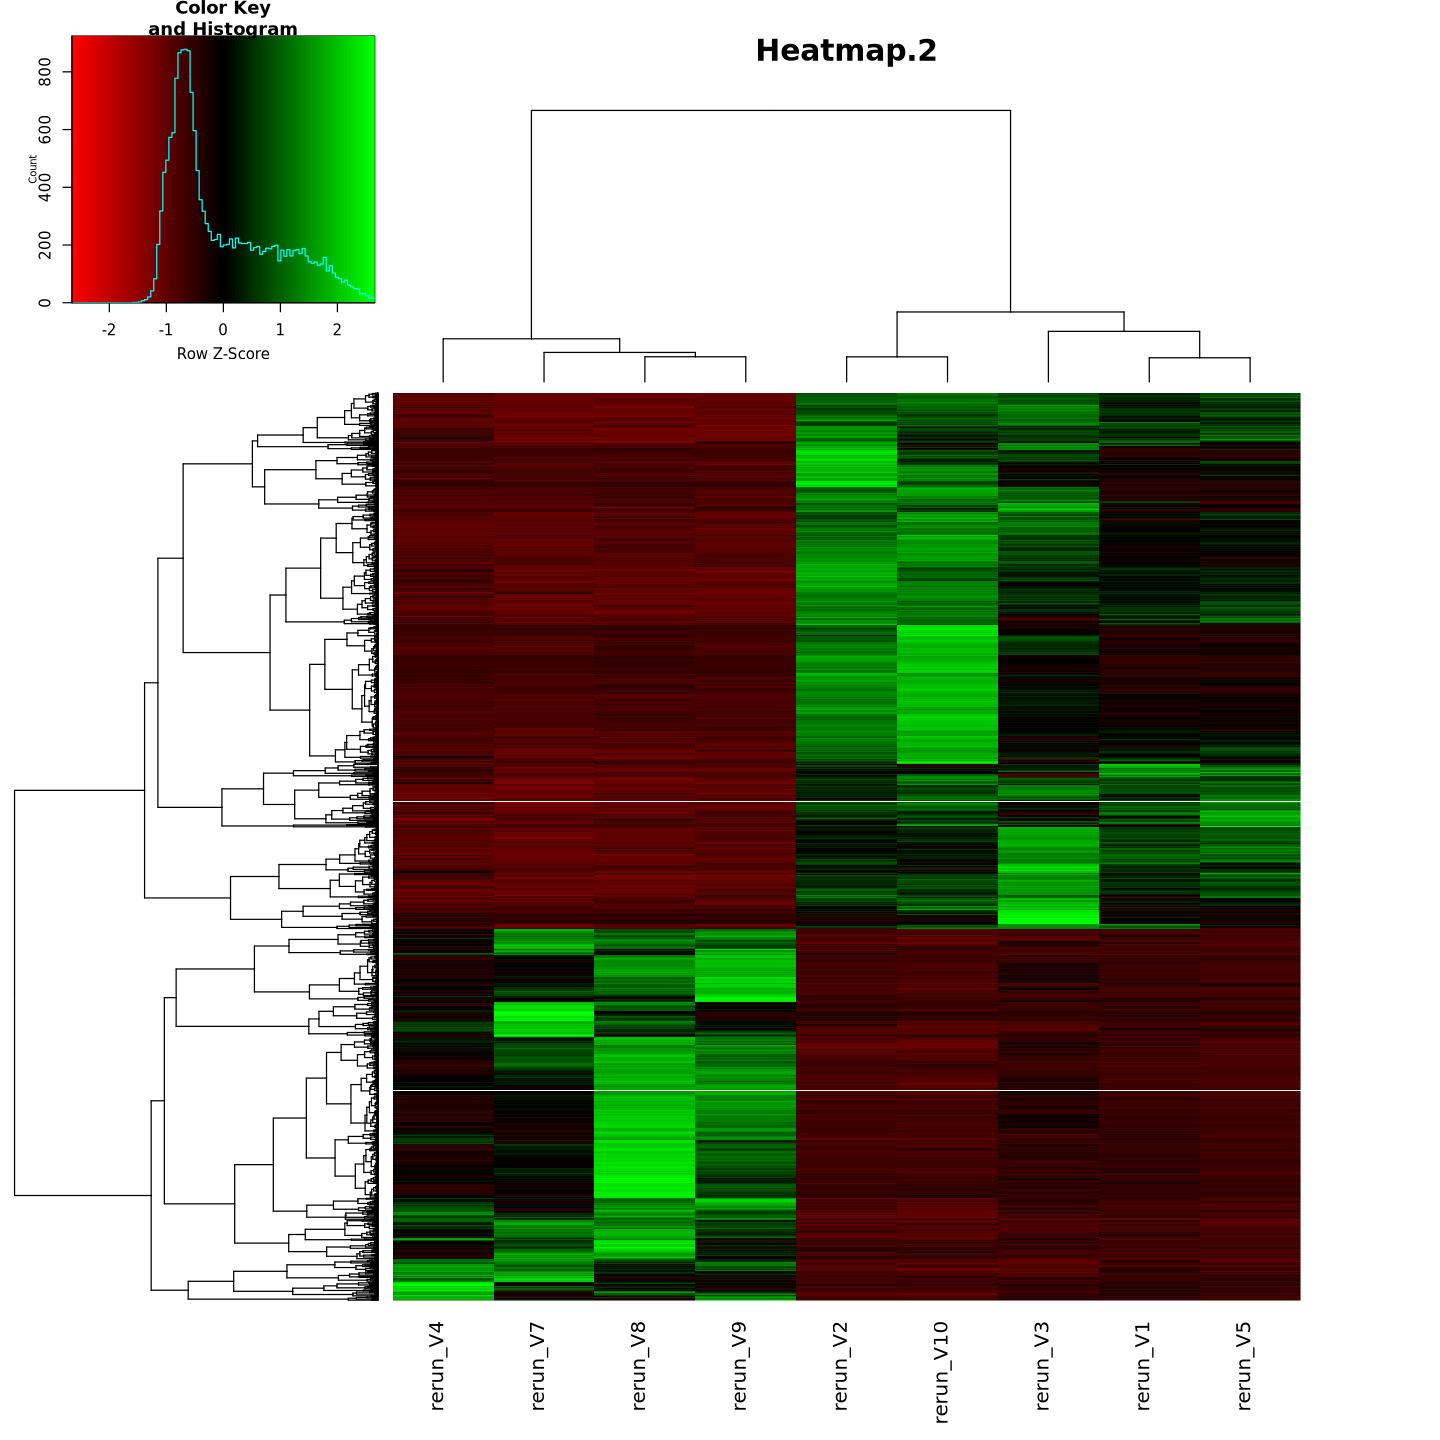

In [51]:
# Set the size of the plot device
options(repr.plot.width = 12, repr.plot.height = 12) 

heatmap.2(DEgenes,
          Rowv=as.dendrogram(hr), 
          Colv=as.dendrogram(hc),
          col=redgreen(100),
          scale="row",
          margins = c(7, 7),
          cexCol = 1.2,
          labRow = F,
          cexRow = 1.2, # Increase row label font size
          main = "Heatmap.2",
          trace = "none")

# Save the plot as a PDF file
pdf("heatmap_plot.pdf", width = 12, height = 12)  # Adjust width and height as needed
dev.off()  # Close the PDF device

## clustering on height of the tree

In [52]:
hclusth1.5 = cutree(hr, h=1.5) #cut tree at height of 1.5
hclusth1.0 = cutree(hr, h=1.0) #cut tree at height of 1.0
hclusth0.5 = cutree(hr, h=0.5) #cut tree at height of 0.5

In [53]:
# output of the function cuttree is a vector containing the cluster number for each of the genes.
head(hclusth0.5)

NLLv2_murdoch00016.2 NLLv2_murdoch00016.1 NLLv2_murdoch00087.1 
                   1                    1                    2 
NLLv2_murdoch00095.1 NLLv2_murdoch00100.1 NLLv2_murdoch00116.1 
                   3                    4                    5

In [54]:
# number of clusters
length(unique(hclusth0.5))

[1] 24

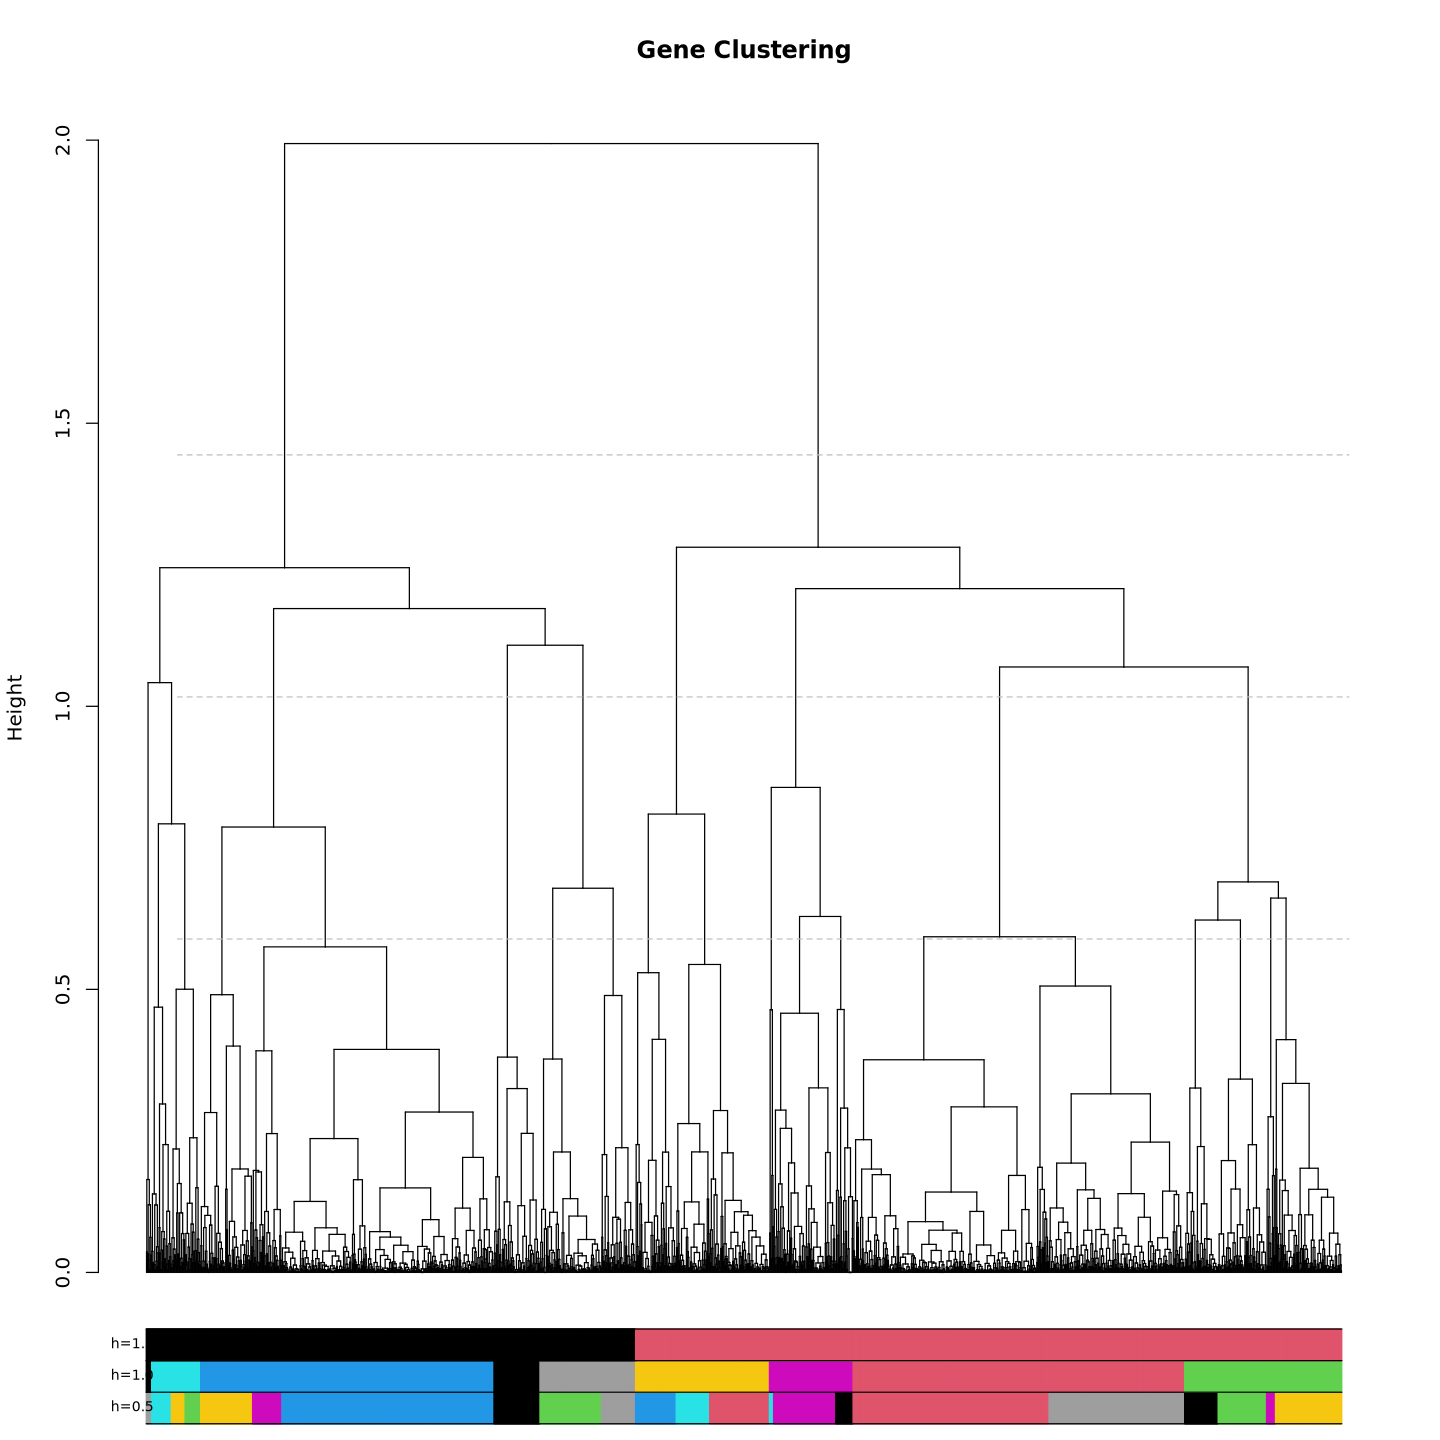

In [55]:
library(dendextend)
#plot the tree
plot(geneTree,
     leaflab = "none",
     main = "Gene Clustering",
     ylab = "Height")

#add the three cluster vectors
the_bars <- cbind(hclusth0.5, hclusth1.0, hclusth1.5)
#this makes the bar
colored_bars(the_bars, geneTree, sort_by_labels_order = T, y_shift=-0.1, rowLabels = c("h=0.5","h=1.0","h=1.5"),cex.rowLabels=0.7)
#this will add lines showing the cut heights
abline(h=1.5, lty = 2, col="grey")
abline(h=1.0, lty = 2, col="grey")
abline(h=0.5, lty = 2, col="grey")

In [92]:
# alternatively it is also posible to set the number of cluster you want.
hclustk10 = cutree(hr, k=4)

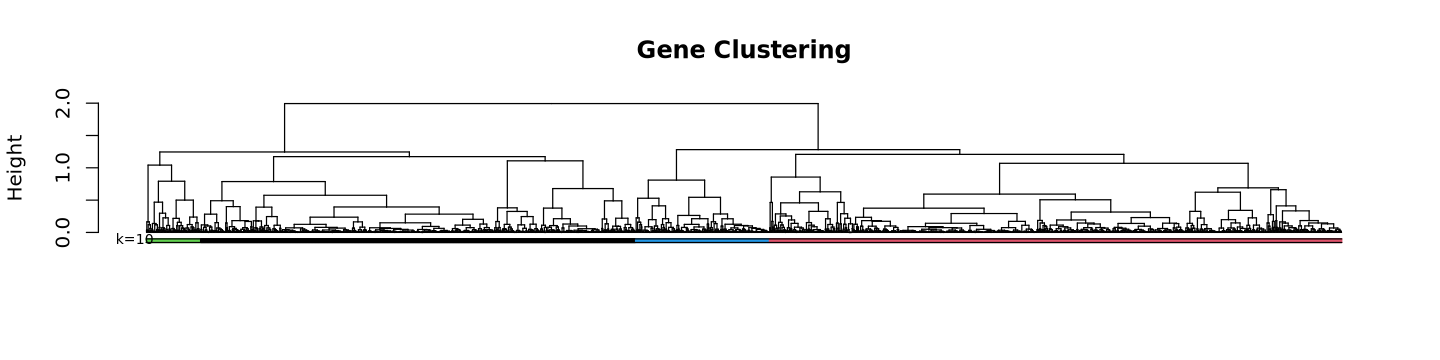

In [93]:
plot(geneTree,
     leaflab = "none",
     main = "Gene Clustering",
     ylab = "Height")
colored_bars(hclustk10, geneTree, sort_by_labels_order = T, y_shift=-0.1, rowLabels = c("k=10"),cex.rowLabels=0.7)

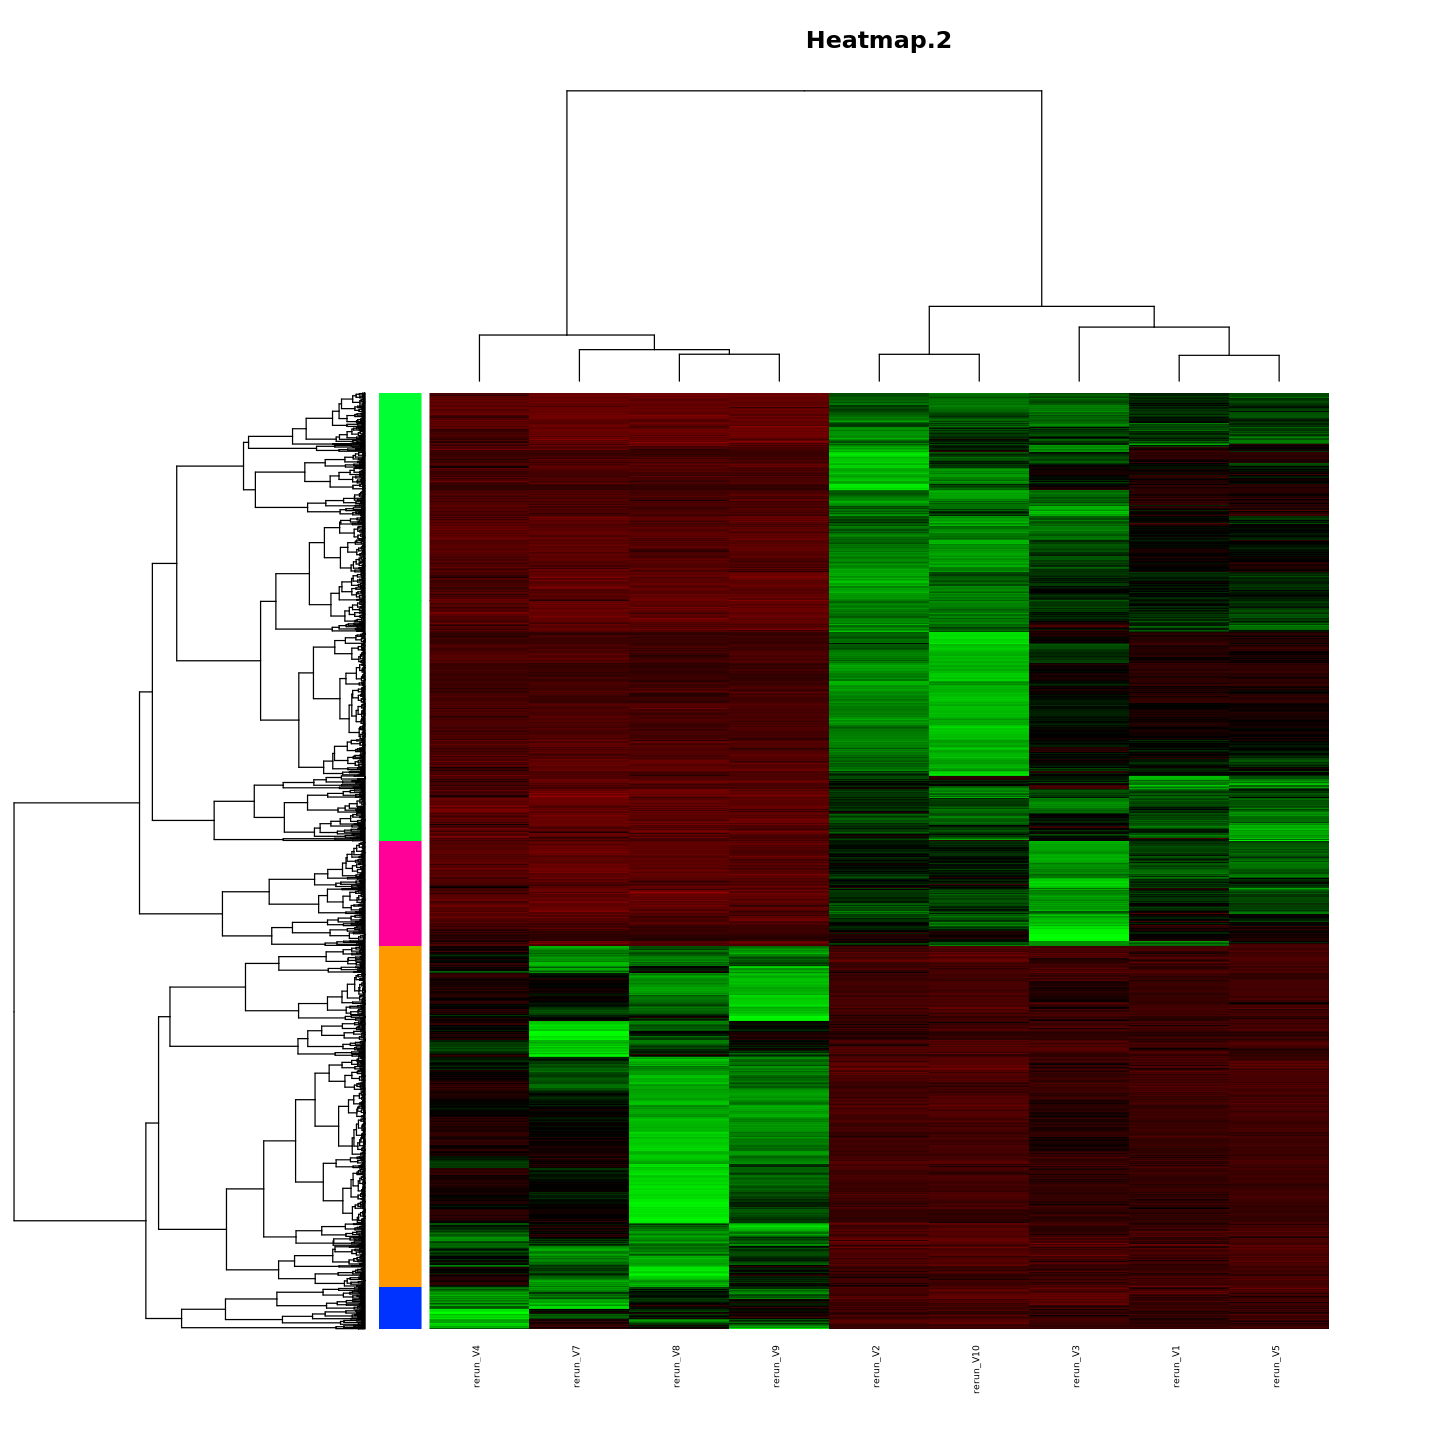

In [105]:
# It is also posible to visualize the bar indicating the clusters in combination with a heatmap.
# This will make it more easy to see if you choose the right number of clusters.
options(repr.plot.width=12, repr.plot.height=12)
clustColBar <- rainbow(length(unique(hclustk10)), start=0.1, end=0.9)
clustColBar <- clustColBar[as.vector(hclustk10)]

heatmap.2(DEgenes,
          Rowv=as.dendrogram(hr), 
          Colv=as.dendrogram(hc),
          col=redgreen(100),
          scale="row",
          margins = c(7, 7),
          cexCol = 0.7,
          labRow = F,
          main = "Heatmap.2",
          trace = "none",
          RowSideColors=clustColBar,
          key = FALSE)

## Looking at the individual clusters

In [95]:
clust.core = function(i, dat, clusters) {
  ind = (clusters == i)
  colMeans(dat[ind,])
}

clusters <- hclustk10
cores <- sapply(unique(clusters), clust.core, scaledata, clusters)

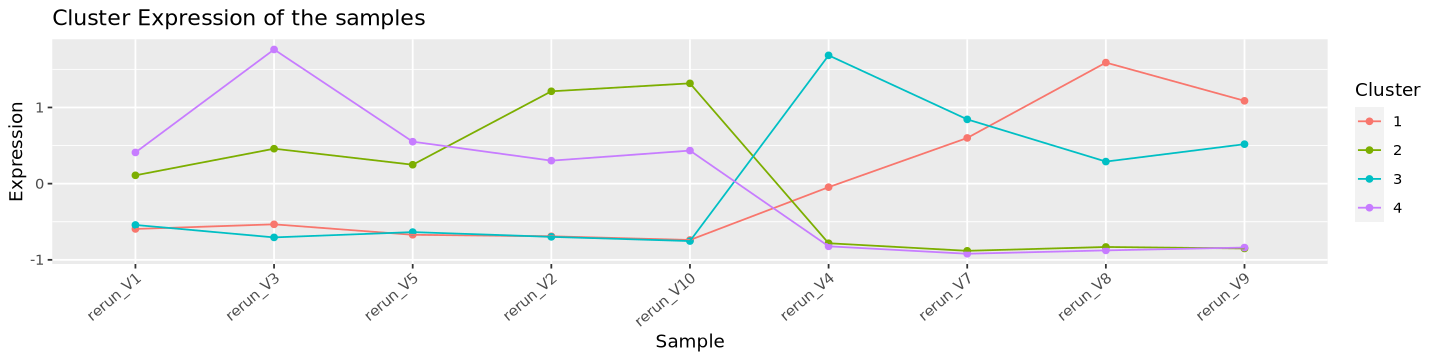

In [96]:
library(reshape2)
options(repr.plot.width=12, repr.plot.height=3)
moltenCores <- melt(cores) ## get the data in a "long" format
colnames(moltenCores) <- c('sample','cluster','value')

ggplot(moltenCores, aes(x=sample,y=value, group=cluster, colour=as.factor(cluster))) + 
  geom_point() + 
  geom_line() +
  xlab("Sample") +
  ylab("Expression") +
  labs(title= "Cluster Expression of the samples",color = "Cluster") +
  theme(axis.text.x = element_text(angle = 40, hjust = 1))

In [97]:
clust2 <- t(scaledata[hclustk5==2,])
clust4 <- t(scaledata[hclustk5==4,])

In [98]:
library(gridExtra)

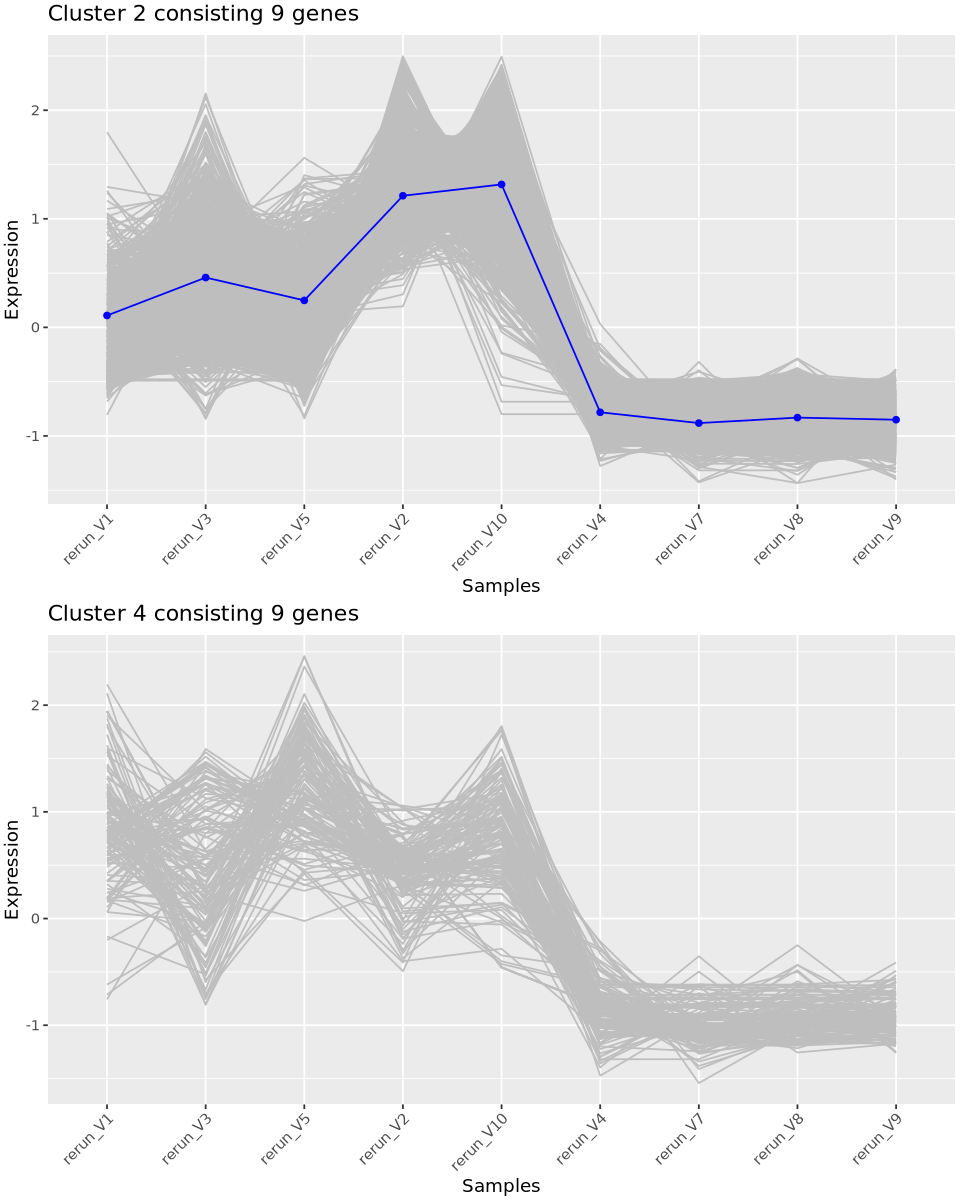

In [99]:
#get the data frame into long format for plotting
# Change plot size in Jupyter Notebook
options(repr.plot.width=8, repr.plot.height=10)

clust4Molten1 <- melt(clust2, id.vars = "Sample")
clust4Molten2 <- melt(clust4, id.vars = "Sample")
colnames(clust4Molten1) <- c('sample','gene','value')
colnames(clust4Molten2) <- c('sample','gene','value')

#Subset the cores molten dataframe so we can plot core4
core1 <- moltenCores[moltenCores$cluster==2,]
core2 <- moltenCores[moltenCores$cluster==5,]

plot1 <- ggplot(clust4Molten1, aes(x=sample,y=value)) + 
  geom_line(color="grey", aes(color="grey", group=gene)) +
  #this adds the core 
  geom_line(data=core1, aes(sample,value, group=cluster), color="blue",inherit.aes=FALSE) +
  geom_point(data=core1, aes(sample,value, group=cluster), color="blue",inherit.aes=FALSE) +
  xlab("Samples") +
  ylab("Expression") +
  labs(title= paste0("Cluster 2 consisting ", nrow(clust2), " genes"),color = "Score") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.margin = unit(rep(0.1, 4), "cm"))

plot2 <- ggplot(clust4Molten2, aes(x=sample,y=value)) + 
  geom_line(color="grey", aes(color="grey", group=gene)) +
  #this adds the core 
  geom_line(data=core2, aes(sample,value, group=cluster), color="blue",inherit.aes=FALSE) +
  geom_point(data=core2, aes(sample,value, group=cluster), color="blue",inherit.aes=FALSE) +
  xlab("Samples") +
  ylab("Expression") +
  labs(title= paste0("Cluster 4 consisting ", nrow(clust5), " genes"),color = "Score") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.margin = unit(rep(0.1, 4), "cm"))

# Arrange the plots into two subplots
grid.arrange(plot1, plot2, nrow =2)

In [100]:
head(scaledata)

,rerun_V1,rerun_V3,rerun_V5,rerun_V2,rerun_V10,rerun_V4,rerun_V7,rerun_V8,rerun_V9
NLLv2_murdoch00016.2,-0.7547287,-0.5734661,-0.71704251,-0.2641806,-0.5571730,-0.57642224,2.1874358,1.01622328,0.2393540
NLLv2_murdoch00016.1,-0.5758702,-0.5042528,-0.60939912,-0.4218134,-0.5793469,-0.16082095,2.4392690,0.69000799,-0.2777737
NLLv2_murdoch00087.1,-0.4755743,0.3882659,-0.09765795,1.4835264,1.7488962,-0.76190454,-0.8894360,-0.63525302,-0.7608626
NLLv2_murdoch00095.1,0.5009237,0.3660736,-0.14702056,2.0442569,0.5531142,-0.34709982,-1.0317719,-0.81981834,-1.1186578
NLLv2_murdoch00100.1,-0.6639371,-0.4195743,-0.81935141,-0.9644283,-0.7074242,0.09314698,0.2790480,1.78377716,1.4187432
NLLv2_murdoch00116.1,-0.4875565,-0.4742256,-0.58418438,-0.6397228,-0.6445307,2.28148445,0.9795105,0.02342915,-0.4542042


In [101]:
scaledata["NLLv2_murdoch17981.1",]

rerun_V1   rerun_V3   rerun_V5   rerun_V2  rerun_V10   rerun_V4   rerun_V7 
 0.5763800  1.0307438  0.8040630  0.9671639  0.7836753 -1.1169647 -1.1528967 
  rerun_V8   rerun_V9 
-0.8005511 -1.0916136

In [102]:
length(hclustk10)

[1] 2001

In [103]:
hclustk10["NLLv2_murdoch17981.1"]

NLLv2_murdoch17981.1 
                   2

In [104]:
genes <- c("NLLv2_murdoch17981.1","NLLv2_murdoch38194.1","NLLv2_murdoch35056.1","NLLv2_murdoch36754.1")
hclustk10[genes]

NLLv2_murdoch17981.1 NLLv2_murdoch38194.1 NLLv2_murdoch35056.1 
                   2                    2                    2 
NLLv2_murdoch36754.1 
                   2